Needed imports

In [237]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

Before starting, use the imageGenerator. In the directory dataclassifier there a file imagecropping.ipynb. This is the place where we get all data for further use in the classifier.

## 1. Setup for smoother use

In [203]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 2. Loading data

In [204]:
# Declaring image path where data is stored
IMG_DIR = '../imageGenerator/data_classifier_cropped'

# Creating tensorflow dataset from directory
class_data = tf.keras.utils.image_dataset_from_directory(IMG_DIR, batch_size=16)

Found 285 files belonging to 2 classes.


In [205]:
# Set class data to iterator to loop through
class_data_iterator = class_data.as_numpy_iterator()

In [206]:
# Take a random batch (32 files)
batch = class_data_iterator.next()

# Check batch length
len(batch) # first array = images, second array = classes

2

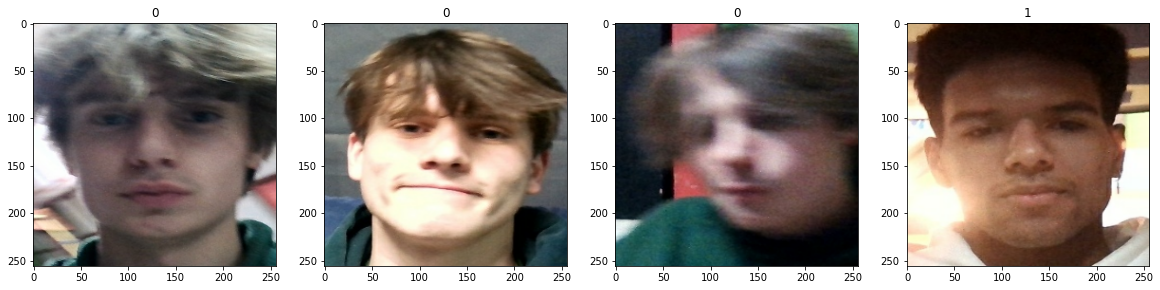

In [207]:
# Plot the batch to see the classes
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 3. Preprocessing data

3.1 Scale data

In [208]:
# Using .map() function to scale the data via lambda function
class_data = class_data.map(lambda x,y: (x/255, y))

In [209]:
# We see much smaller values right now, scaling succesful
class_data.as_numpy_iterator().next()

(array([[[[0.11372549, 0.20784314, 0.14509805],
          [0.12388174, 0.21799938, 0.15525429],
          [0.1380821 , 0.23282015, 0.16986826],
          ...,
          [0.6119715 , 0.49432445, 0.54138327],
          [0.60284925, 0.4852022 , 0.5278033 ],
          [0.59607846, 0.47843137, 0.5176471 ]],
 
         [[0.1321538 , 0.22627145, 0.16352634],
          [0.13700712, 0.23112476, 0.16837966],
          [0.1440629 , 0.23831506, 0.17552513],
          ...,
          [0.6119715 , 0.49432445, 0.54138327],
          [0.60284925, 0.4852022 , 0.5278033 ],
          [0.59607846, 0.47843137, 0.5176471 ]],
 
         [[0.15228248, 0.24389553, 0.17614123],
          [0.15026246, 0.24403769, 0.17520231],
          [0.14769472, 0.24431697, 0.17405808],
          ...,
          [0.5972081 , 0.48457024, 0.531629  ],
          [0.5892452 , 0.47660732, 0.52205545],
          [0.58355546, 0.47091758, 0.51514244]],
 
         ...,
 
         [[0.08311121, 0.27526808, 0.29095435],
          [0.09481

3.2 Split data

In [210]:
# Check amount of batches in class_data
len(class_data)

18

In [211]:
# Declaring sizes for train, test and val sets
train_size = int(len(class_data)*.7)
val_size = int(len(class_data)*.2)
test_size = int(len(class_data)*.1)

In [212]:
# Check test size if big enough, otherwise we need more data or smaller batches
test_size

1

In [213]:
# Split data via take and skip
# DATA MUST BE SHUFFLED BEFORE!! image_dataset_from_directory --> default shuffle = True
train = class_data.take(train_size)
val = class_data.skip(train_size).take(val_size)
test = class_data.skip(train_size+val_size).take(test_size)

## 4. Deep learning model

4.1 Building the deep learning model

In [214]:
# Declare sequential model
model = Sequential()

In [215]:
# Three convolution blocks, Flatten layer and Dense layers

# Relu for converting neg values to zero and positive values remain unchanged
# Input shape = image sizes
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# Reduce image data by half (pool of (2,2))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Flatten data down to give to Dense layers
model.add(Flatten())

model.add(Dense(256, activation='relu'))
# Single output 0 or 1 because of sigmoid (0 and 1 are also the classes)
model.add(Dense(1, activation='sigmoid'))

In [216]:
# Compiling the model
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [217]:
# Check out the layers and total params
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 16)      

4.2 Train

In [218]:
logdir='logs'

In [219]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [220]:
# Train model via .fit() method
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
12/12 [==============================] - 8s 586ms/step - loss: 1.0071 - accuracy: 0.6198 - val_loss: 0.4497 - val_accuracy: 0.8333
Epoch 2/20
12/12 [==============================] - 7s 566ms/step - loss: 0.3382 - accuracy: 0.8542 - val_loss: 0.1616 - val_accuracy: 0.9583
Epoch 3/20
12/12 [==============================] - 7s 555ms/step - loss: 0.1011 - accuracy: 0.9740 - val_loss: 0.0665 - val_accuracy: 0.9792
Epoch 4/20
12/12 [==============================] - 7s 533ms/step - loss: 0.0379 - accuracy: 0.9896 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 5/20
12/12 [==============================] - 7s 576ms/step - loss: 0.0225 - accuracy: 0.9896 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 6/20
12/12 [==============================] - 7s 596ms/step - loss: 0.0162 - accuracy: 0.9896 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 7/20
12/12 [==============================] - 8s 627ms/step - loss: 0.0096 - accuracy: 0.9948 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 

4.3 Plot Performance

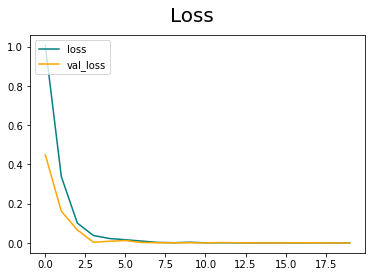

In [221]:
# Plotting the loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

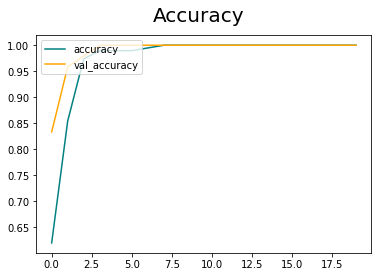

In [222]:
# Plotting the accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 5. Evaluate performance

5.1 Evaluate

In [224]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [225]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    # For every batch in test set, make a prediction
    yhat = model.predict(X)

    # Update metrics
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [228]:
# Print results of test set
print(f'Precision: {pre.result()*100}%, Recall: {re.result()*100}%, Accuracy {acc.result()*100}%')

Precision: 100.0%, Recall: 100.0%, Accuracy 100.0%


5.2 Test

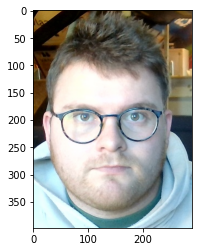

In [229]:
# Choose the test image (2 options: input from camera in facedetector or self chosen test images)
# Read in image
# img = cv2.imread('../faceDetector/input_image/input_image.jpg')
img = cv2.imread('./test_images/senne_cam.jpg')

# Convert colors
im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot image
plt.imshow(im_rgb)
plt.show()

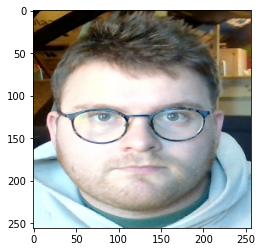

In [230]:
# Resize image to 256, 256
resize = tf.image.resize(im_rgb, (256,256))

# Plot image again
plt.imshow(resize.numpy().astype(int))
plt.show()

In [231]:
# Do prediction on new image
yhat = model.predict(np.expand_dims(resize/255, 0))

In [235]:
# Check score
yhat[0][0]

0.9999989

5.3 Make decision

In [236]:
# Decide wether face is member or intruder
# Because we are opening a door, we take a higher value
if yhat > 0.85: 
    print(f'Predicted class is member')
else:
    print(f'Predicted class is intruder')

Predicted class is member


## 6. Save model

In [238]:
model.save('imageclassifier.h5')